In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import scipy.stats
import mpi4py.MPI as mpi
from il1beta_model import Il1bModel as Model
from pypacmensl.fsp_solver import FspSolverMultiSinks

In [28]:
with np.load('il1b_mcmc_full.npz') as f:
#     par_full = np.mean(f['theta'][:,:,-1], axis=0)
    idx = np.argmax(f['loglike'][:,-1])
    par_full = f['theta'][idx,:,-1]

with np.load('il1b_mcmc_multifi.npz') as f:
#     par_multi = np.mean(f['theta'][:,:,-1], axis=0)
    idx = np.argmax(f['loglike'][:,-1])
    par_multi = f['theta'][idx,:,-1]
    
with np.load('il1b_mcmc_tuned.npz') as f:
#     par_tuned = np.mean(f['theta'][:,:,-1], axis=0)    
    idx = np.argmax(f['loglike'][:,-1])
    par_tuned = f['theta'][idx,:,-1]    
    
with np.load('il1b_mcmc_bridge.npz') as f:
#     par_bridge = np.mean(f['theta'][:,:,-1], axis=0)    
    idx = np.argmax(f['loglike'][:,-1])
    par_bridge = f['theta'][idx,:,-1]

par_opt = np.array(
[
    -2.39942472, 
    -2., 
    -3.20775953, 
    -1.66146085, 
    3.69897,
    -3.18677747, 
    -2.4970468, 
    -3.11371105, 
    -0.43187213, 
    -4.24823665, 4.936513742478893
]
)

In [29]:
with np.load('il1b_mcmc_full.npz') as f:
    idx = np.argmax(f['loglike'][:,-1])
    print(f['loglike'][idx,-1])

-71355.13521718327


In [30]:
MODEL = Model()
T_MEASUREMENTS = np.array([0, 0.5, 1, 2, 4]) * 3600

def solve_model(log10_theta):
        def fsp_constr(X, out):
            out[:, 0] = X[:, 0]
            out[:, 1] = X[:, 1]
            out[:, 2] = X[:, 2]
            out[:, 3] = X[:, 3]
            out[:, 4] = X[:, 3]

        theta = np.power(10.0, log10_theta)
        copymax = MODEL.copymaxs[MODEL.num_surrogates-1]
        constr_init = np.array([2, 2, 2, 5, copymax])
        propensity_t, propensity_x = MODEL.propensity_factory(theta, MODEL.num_surrogates-1)
        SOLVER0 = FspSolverMultiSinks(mpi.COMM_SELF)
        SOLVER0.SetVerbosity(2)
        SOLVER0.SetModel(MODEL.stoichm, propensity_t, propensity_x, [1])
        SOLVER0.SetFspShape(constr_fun=fsp_constr, constr_bound=constr_init, 
                            exp_factors=np.array([0.0, 0.0, 0.0, 0.2, 0.0]))
        SOLVER0.SetInitialDist(MODEL.X0, MODEL.P0)
        SOLVER0.SetOdeSolver(MODEL.ode_solver)
        SOLVER0.SetOdeTolerances(1.0e-4, 1.0e-10)
        SOLVER0.SetUp()
        solutions = SOLVER0.SolveTspan(T_MEASUREMENTS + theta[-1], 1.0E-8)
        SOLVER0.ClearState()
        return solutions

def get_marginals(solutions):
    marginals = []
    for it in range(0,len(T_MEASUREMENTS)):
        marginals.append(solutions[it].Marginal(3))

    return marginals

Il1beta model.



In [31]:
sol_multi = solve_model(par_multi)
sol_tuned = solve_model(par_tuned)
sol_full = solve_model(par_full)
sol_bridge = solve_model(par_bridge)
sol_opt = solve_model(par_opt)

In [32]:
mars_multi = get_marginals(sol_multi)
mars_tuned = get_marginals(sol_tuned)
mars_full = get_marginals(sol_full)
mars_bridge = get_marginals(sol_bridge)
mars_opt = get_marginals(sol_opt)

In [33]:
# data = load_data('NoDrug', 'IL1B', replica=-1)
with np.load('il1b_data.npz', allow_pickle=True) as datfile:
    data = datfile['mrna_counts']

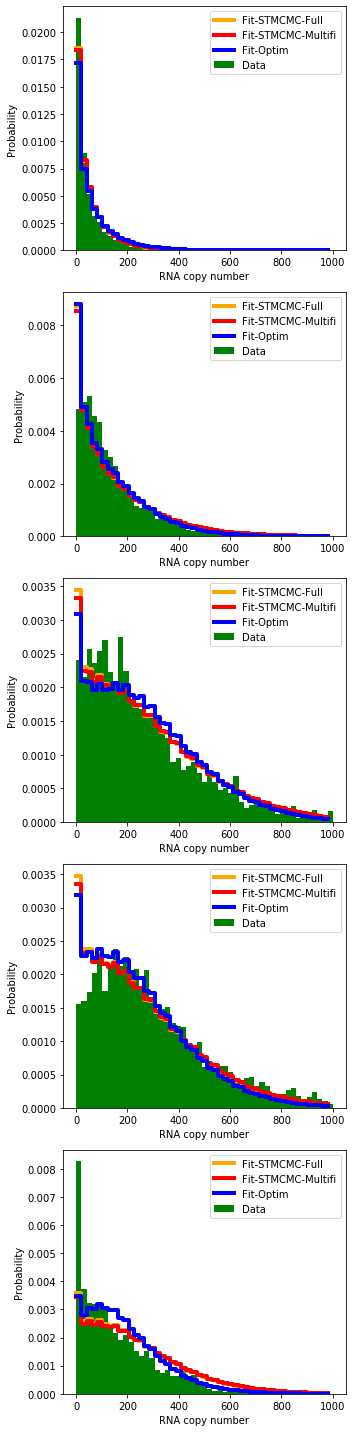

In [34]:
fig, axes = plt.subplots(len(T_MEASUREMENTS), 1)
fig.set_tight_layout(True)
fig.set_size_inches(5, 20)
for j in range(len(T_MEASUREMENTS)):
        mars_mean[j][mars_mean[j] < 0] = 0
        sns.distplot(data[j], ax=axes[j], norm_hist=True, kde=False, label="Data", 
                     color="Green", bins=np.linspace(0, 1000, 50), hist_kws={'alpha': 1})
        
        xmax = len(mars_mean[j])
        fit_h, fit_edges = np.histogram(np.arange(0, xmax), 
                                        bins=np.linspace(0, 1000, 50), 
                                        weights=mars_full[j], density=True)
        sns.lineplot(fit_edges[0:-1], fit_h, ax=axes[j], label="Fit-STMCMC-Full", 
                     color="Orange", linewidth=4, alpha=1, drawstyle='steps-post')
        
        xmax = len(mars_map[j])
        fit_h, fit_edges = np.histogram(np.arange(0, xmax), 
                                        bins=np.linspace(0, 1000, 50), 
                                        weights=mars_multi[j], density=True)
        sns.lineplot(fit_edges[0:-1], fit_h, ax=axes[j], label="Fit-STMCMC-Multifi", 
                     color="Red", linewidth=4, alpha=1, drawstyle='steps-post')
        
        xmax = len(mars_opt[j])
        fit_h, fit_edges = np.histogram(np.arange(0, xmax), 
                                        bins=np.linspace(0, 1000, 50), 
                                        weights=mars_opt[j], density=True)
        sns.lineplot(fit_edges[0:-1], fit_h, ax=axes[j], label="Fit-Optim", 
                     color="blue", linewidth=4, alpha=1, drawstyle='steps-post')
        
        pos = axes[j].get_position()
        axes[j].set_ylabel('Probability')
        axes[j].set_xlabel('RNA copy number')
fig.savefig('inflam_fits.pdf')        